In [246]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

import cv2
from PIL import Image

import glob
import time

# Data loader

In [247]:
def show_images(images, size=(10, 6), title=""):
    fig, axes = plt.subplots(1, len(images), figsize=size)
    for idx, image in enumerate(images):
        axes[idx].imshow(image)
    fig.suptitle(title, fontsize=12)
    plt.show()

In [248]:
def data_loader(path: str, appear: bool = False, show_size=(12, 6), title: str = "Original Data"):
    image_paths = sorted(glob.glob(path))
    images = [cv2.imread(path, cv2.IMREAD_UNCHANGED) for path in image_paths]
    if appear:
        show_images(images, show_size, title)
    return images

# Data cleaning

In [249]:
def normalize_images(images, appear: bool = False, title: str = "Nomalized Images"):
    normal_images = [(image / np.max(image) * 255).astype(np.uint8) for image in images]
    if appear:
        show_images(normal_images, title=title)
    return normal_images

In [250]:
def to_gray_images(images, appear=False, title: str = "Gray Images"):
    gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
                   for image in images]
    if appear:
        show_images(gray_images, title=title)
    return gray_images

# Feature detector

In [251]:
def harris_corner_detector(images: list, block_size: int, k_size: int, k_harris_parameter=0.04, threshold=0.01,
                          appear=False):
    key_points = []
    for img in images:
        corner = cv2.cornerHarris(img, block_size, k_size, k_harris_parameter)
        corner = cv2.dilate(corner, None)

        points = np.argwhere(corner > threshold * corner.max())
        keypoint = [cv2.KeyPoint(float(x[1]), float(x[0]), 1) for x in points]

        key_points.append(keypoint)

    if appear:
        plot_key_points(images, key_points)

    return key_points

In [252]:
def plot_key_points(images, key_points):
    _, axes = plt.subplots(1, len(images), figsize=(10, 6))
    for idx, image in enumerate(images):
        points = np.array([list(keypoint.pt) for keypoint in key_points[idx]])
        axes[idx].imshow(image)
        axes[idx].scatter(points[:, 0], points[:, 1], marker='x', color='r')
    plt.show()

# Image matching

In [253]:
def SIFT_description(gray_images, key_points):
    detector = cv2.SIFT_create()

    descriptors = []
    for idx, img in enumerate(gray_images):
        keypoint, descriptor = detector.compute(img, key_points[idx])

        descriptors.append(descriptor)

    return key_points, descriptors

In [254]:
def SUFR_description(gray_images):
    detector = cv2.xfeatures2d.SURF_create()

    key_points = []
    descriptors = []

    for idx, img in enumerate(gray_images):
        keypoint = detector.detect(img, None)
        keypoint, descriptor = detector.compute(img, keypoint)

        key_points.append(keypoint)
        descriptors.append(descriptor)

    return key_points, descriptors

In [255]:
def ORB_description(gray_images):
    detector = cv2.ORB_create()

    key_points = []
    descriptors = []

    for idx, img in enumerate(gray_images):
        keypoint, descriptor = detector.detectAndCompute(img, None)

        key_points.append(keypoint)
        descriptors.append(descriptor)

    return key_points, descriptors

In [256]:
def KAZE_description(gray_images):
    detector =  cv2.KAZE_create()

    key_points = []
    descriptors = []

    for idx, img in enumerate(gray_images):
        keypoint = detector.detect(img, None)
        keypoint, descriptor = detector.compute(img, keypoint)

        key_points.append(keypoint)
        descriptors.append(descriptor)
        
    return key_points, descriptors

In [257]:
def FREAK_description(gray_images):
    STAR = cv2.xfeatures2d.StarDetector_create()
    detector = cv2.xfeatures2d.FREAK_create()

    key_points = []
    descriptors = []
    for idx, img in enumerate(gray_images):
        keypoint = STAR.detect(img, None)
        keypoint, descriptor = detector.compute(img, keypoint)
        
        key_points.append(keypoint)
        descriptors.append(descriptor)

    return key_points, descriptors

In [258]:
def BRISK_description(gray_images):
    detector = cv2.BRISK_create()

    key_points = []
    descriptors = []

    for idx, img in enumerate(gray_images):
        keypoint = detector.detect(img, None)
        keypoint, descriptor = detector.compute(img, keypoint)

        key_points.append(keypoint)
        descriptors.append(descriptor)
        
    return key_points, descriptors

In [259]:
def BRIEF_description(gray_images):
    STAR = cv2.xfeatures2d.StarDetector_create()
    detector = cv2.xfeatures2d.BriefDescriptorExtractor_create()

    key_points = []
    descriptors = []
    for idx, img in enumerate(gray_images):
        keypoint = STAR.detect(img, None)
        keypoint, descriptor = detector.compute(img, keypoint)
        
        key_points.append(keypoint)
        descriptors.append(descriptor)

    return key_points, descriptors

In [260]:
def AKAZE_description(gray_images):
    detector =  cv2.AKAZE_create()

    key_points = []
    descriptors = []

    for idx, img in enumerate(gray_images):
        keypoint = detector.detect(img, None)
        keypoint, descriptor = detector.compute(img, keypoint)

        key_points.append(keypoint)
        descriptors.append(descriptor)
        
    return key_points, descriptors

In [261]:
def matching_conner(imgs, key_points, descriptors, type_match="original", num_top_matches=50, ratio_thresh=0.3, appear=False, method='SIFT'):
    #src image
    src_key_points = key_points[0]
    src_descriptors = descriptors[0]

    # des image
    des_key_points = key_points[1]
    des_descriptors = descriptors[1]
    
    # Match descriptors using FLANN matcher
    if method in ["ORB", "FREAK", "BRISK", "BRIEF", "AKAZE"]:
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        type_match="original"
    else:
        matcher = cv2.FlannBasedMatcher()

    if type_match == "original":
        matches = matcher.match(src_descriptors, des_descriptors)

        # Sort matches by distance
        matches = sorted(matches, key=lambda x: x.distance)

        # Select top matches
        matches = matches[:num_top_matches]

    if type_match == "knn":
        knn_matches = matcher.knnMatch(src_descriptors, des_descriptors, 2)

        # Filter matches using the Lowe's ratio test
        ratio_thresh = ratio_thresh
        matches = []
        for m,n in knn_matches:
            if m.distance < ratio_thresh * n.distance:
                matches.append(m)

    # Extract matched keypoints
    src_points = np.float32([src_key_points[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    des_points = np.float32([des_key_points[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    if appear:
        plot_matches(imgs[0], imgs[1], src_points, des_points)

    return src_points, des_points

In [262]:
# use this function to visualize the matches
def plot_matches(src_img, des_img, src_points, des_points):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # draw images
    axes[0].imshow(src_img)
    axes[1].imshow(des_img)

    # draw matches
    for src_point, des_point in zip(src_points, des_points):
        kp1, kp2 = src_point[0], des_point[0]

        con = ConnectionPatch(xyA=kp1, coordsA=axes[0].transData,
                              xyB=kp2, coordsB=axes[1].transData, color='r')
        fig.add_artist(con)
        axes[0].plot(*kp1, color='r', marker='x')
        axes[1].plot(*kp2, color='r', marker='x')

    plt.show()

# Global alignment

# Blending and Compositing

In [263]:
def warpTwoImages(img_src, img_des, H, appear=False):
    # Warp the source image to align with the destination image 
    h1, w1 = img_src.shape[:2]
    h2, w2 = img_des.shape[:2]

    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)

    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    wrap_src_img = cv2.warpPerspective(img_src, Ht.dot(H), (xmax - xmin, ymax - ymin))

    # Combine the two images into a panorama
    wrap_src_img[t[1]:h2 + t[1], t[0]:w2 + t[0]] = img_des

    if appear:
        plt.imshow(wrap_src_img)
        plt.title('Panorama result')
        plt.show()

    return wrap_src_img  #%%

## Main function

In [264]:
def stitching_images(img_src, img_des, method='SIFT'):
    ## Normalize values, change data type
    images_norm_uint8 = normalize_images([img_src, img_des])

    ## Grayscale images
    gray_images = to_gray_images(images_norm_uint8)

    ## Harris conner detector
    key_points = harris_corner_detector(gray_images,
                                    block_size=2,
                                    k_size=3,
                                    k_harris_parameter=0.04,
                                    threshold=0.01,
                                    appear=False)

    ## Description of each corner
    if method == 'SIFT':
        key_points, descriptors = SIFT_description(gray_images, key_points)
    
    if method == 'SURF':
        # SURF is the same idea as SIFT, but it's patented
        # to run it, we need old version of opencv < 3.4.
        key_points, descriptors = SUFR_description(gray_images)

    if method == 'ORB':
        key_points, descriptors = ORB_description(gray_images)

    if method == 'KAZE':
        key_points, descriptors = KAZE_description(gray_images)
    
    if method == 'FREAK':
        key_points, descriptors = FREAK_description(gray_images)

    if method == 'BRISK':
        key_points, descriptors = BRISK_description(gray_images)

    if method == 'BRIEF':
        key_points, descriptors = BRIEF_description(gray_images)

    if method == 'AKAZE':
        key_points, descriptors = AKAZE_description(gray_images)

    ## Matching corner
    src_points, des_points = matching_conner([img_src, img_des],
                                                key_points, descriptors,
                                                type_match="knn",
                                                num_top_matches=50,
                                                ratio_thresh=0.3,
                                                appear=True,
                                                method=method)

    ## Compute homography matrix using RANSAC
    H, mask = cv2.findHomography(src_points, des_points, cv2.RANSAC, 10.0)

    ## Find the size of new panorama
    panorama = warpTwoImages(img_src, img_des, H, appear=True)

    return panorama

# HARRIS_IMAGE_RESULT = stitching_images_harris_test()

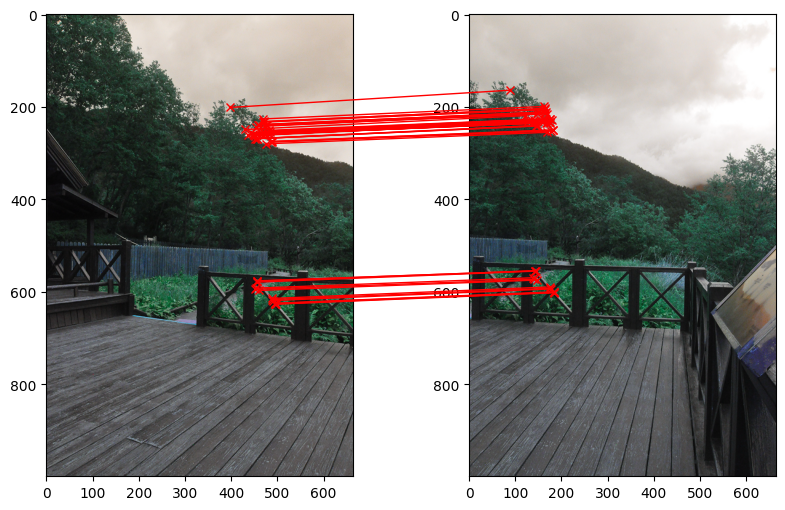

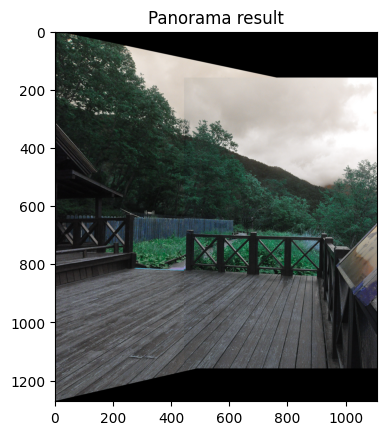

Final image: MSE = 91.55, PSNR = 10.09
Processing time: 2.15 seconds


In [265]:
def multi_panorama():
    # Load images. CV2 reads in BGR format
    images = data_loader('data/xue-mountain/*.jpg')[:2]

    firs_images = images[0]
    for i in range(1, len(images)):

        # method = ['SIFT', 'SURF', 'ORB', 'KAZE', 'FREAK', 'BRISK', 'BRIEF', 'AKAZE']
        method = 'ORB'

        new_firs_images = stitching_images(firs_images, images[i], method = method)

        firs_images = new_firs_images.copy()

    # Resize final stitched image to match dimensions of first image
    firs_images = cv2.resize(firs_images, (images[0].shape[1], images[0].shape[0]))

    # Calculate MSE and PSNR of the final stitched image
    mse_val = np.mean((firs_images - images[0])**2)
    psnr_val = cv2.PSNR(firs_images, images[0])
    print(f"Final image: MSE = {mse_val:.2f}, PSNR = {psnr_val:.2f}")

    return firs_images

start_time = time.time()
PANORAMA = multi_panorama()
end_time = time.time()
# Calculate the processing time
processing_time = end_time - start_time
print(f"Processing time: {processing_time:.2f} seconds")


# Output

In [266]:
### General code structure

def stitching_images(img_src: np.array, img_des: np.array):
    gd_src = rgb2gray(img_src)
    gd_des = rgb2gray(img_des)

    ### TODO: Harris conner detecting and the patches - areas around conners

    ### TODO: SIFT computing the feature description by gradient of each patch

    ### TODO: Compute distance matrix based on SIFT of each patch

    ### TODO: Match each patch with from distance matrix above

    ### TODO: Run RANSAC to remove the outline pair of patch

    ### TODO: Composite two images into one

    ### TODO: Normalize the images (e.g. have same brightness levels)

   # return [combined_image, Harris, num_inliers, residual]#%% md
## Main function